<a href="https://colab.research.google.com/github/liangliangzhuang/PdM/blob/main/1215_bearing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 导入第三方库

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.getcwd()
os.chdir('/content/gdrive/MyDrive/DBL2021')

Mounted at /content/gdrive


In [2]:
import pickle as pkl
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt

## 导入数据

In [7]:
def load_data_from_pfile(file_path):
    with open(file_path, 'rb') as pfile:
        sample_data = pkl.load(pfile)
    return sample_data

In [8]:
class PHMDataset(Dataset):
    '''
    PHM IEEE 2012 Data Challenge Training data set (6 different Mechanical Bearings data)
    '''
    def __init__(self, pfiles=[]):
        self.data = {'x': [], 'y': []}
        for pfile in pfiles:
            _data = load_data_from_pfile(pfile)
            self.data['x'].append(_data['x'])
            self.data['y'].append(_data['y'])
        self.data['x'] = np.concatenate(self.data['x'])
        self.data['y'] = np.concatenate(self.data['y'])[:,np.newaxis]
    
    def __len__(self):
        return self.data['x'].shape[0]
    
    def __getitem__(self, i):
        sample = {'x': torch.from_numpy(self.data['x'][i]), 'y': torch.from_numpy(self.data['y'][i])}
        return sample

In [9]:
pkzfiles_path = 'Dataset/Bearing/'

train_pfiles = [pkzfiles_path+'bearing1_1_train_data.pkz', pkzfiles_path+'bearing1_2_train_data.pkz', \
                pkzfiles_path+'bearing2_1_train_data.pkz', pkzfiles_path+'bearing2_2_train_data.pkz', \
                pkzfiles_path+'bearing3_1_train_data.pkz', pkzfiles_path+'bearing3_2_train_data.pkz']

val_pfiles = [pkzfiles_path+'bearing1_1_val_data.pkz', pkzfiles_path+'bearing1_2_val_data.pkz', \
              pkzfiles_path+'bearing2_1_val_data.pkz', pkzfiles_path+'bearing2_2_val_data.pkz', \
              pkzfiles_path+'bearing3_1_val_data.pkz', pkzfiles_path+'bearing3_2_val_data.pkz']

In [10]:
train_dataset = PHMDataset(pfiles=train_pfiles)
val_dataset = PHMDataset(pfiles=val_pfiles)
print(len(train_dataset), len(val_dataset))

6783 751


## CNN模型训练

In [11]:
train_batch_size = 64
val_batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=1)
val_dataloader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=True, num_workers=1)

In [12]:
def conv_bn_relu(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', batch_norm=True):
    conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias, padding_mode=padding_mode)
    nn.init.xavier_uniform_(conv.weight)
    relu = nn.ReLU()
    if batch_norm:
        return nn.Sequential(
            conv,
            nn.BatchNorm2d(out_channels),
            relu
        )
    else:
        return nn.Sequential(
            conv,
            relu
        )

In [13]:
class CNN_FP(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = conv_bn_relu(2, 16, 3, stride=1, padding=1, bias=True, batch_norm=True)
        self.pool1 = nn.MaxPool2d(2, stride=2)
        self.conv2 = conv_bn_relu(16, 32, 3, stride=1, padding=1, bias=True, batch_norm=True)
        self.pool2 = nn.MaxPool2d(2, stride=2)
        self.conv3 = conv_bn_relu(32, 64, 3, stride=1, padding=1, bias=True, batch_norm=True)
        self.pool3 = nn.MaxPool2d(2, stride=2)
        self.conv4 = conv_bn_relu(64, 128, 3, stride=1, padding=1, bias=True, batch_norm=True)
        self.pool4 = nn.MaxPool2d(2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(8192, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)
        self.dropout1 = nn.Dropout(p=0.5)
        self.dropout2 = nn.Dropout(p=0.2)

    def forward(self, x):
        # input shape = [Nx2x128x128]
        x = self.conv1(x) # [Nx16x128x128]
        x = self.pool1(x) # [Nx16x64x64]
        x = self.conv2(x) # [Nx32x64x64]
        x = self.pool2(x) # [Nx32x32x32]
        x = self.conv3(x) # [Nx64x32x32]
        x = self.pool3(x) # [Nx64x16x16]
        x = self.conv4(x) # [Nx128x16x16]
        x = self.pool4(x) # [Nx128x8x8]
        x = self.flatten(x) # [Nx8192] {128*8*8=8192} (N => batch size, 128 => no. of channels, 8*8 => height of image*width of image)
        x = self.fc1(x) # [Nx256]
        # x = self.dropout1(x) # apply dropout
        x = nn.ReLU()(x) # apply ReLU activation
        x = self.fc2(x) # [Nx128]
        # x = self.dropout2(x) # apply dropout
        x = nn.ReLU()(x) # apply ReLU activation
        x = self.fc3(x) # final fully connected layer (or) final linear layer [Nx1] -> output is probability of fault
        return x

In [14]:
# 查看是否包含GPU
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Declaring a variable "device" which will hold the device(i.e. either GPU or CPU) we are 
                                                                      #training the model on
print(device)
device
model = CNN_FP().to(device) 

cpu


In [15]:
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=0.001, 
                        betas=(0.9, 0.999), eps=1e-08,
                        weight_decay=0.01, amsgrad=False)
multistep_lr_sch = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,20], 
                                                  gamma=0.1, last_epoch=-1, verbose=False)

In [16]:
def train_epoch(model, dataloader, criterion, optimizer):
    total_loss = 0
    num_of_samples = 0
    model.train()
    for i, batch in enumerate(dataloader):
        x = batch['x'].to(device, dtype=torch.float)
        y = batch['y'].to(device, dtype=torch.float)

        optimizer.zero_grad()
        y_prediction = model(x)
        loss = criterion(y_prediction, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.cpu().item()
        num_of_samples += x.shape[0]
    return total_loss/num_of_samples 


def eval(model, dataloader, criterion):
    total_loss = 0
    num_of_samples = 0
    model.eval()
    for i, batch in enumerate(dataloader):
        x = batch['x'].to(device, dtype=torch.float)
        y = batch['y'].to(device, dtype=torch.float)

        with torch.no_grad():
            y_prediction = model(x)
            loss = criterion(y_prediction, y)

        total_loss += loss.cpu().item()
        num_of_samples += x.shape[0]
    return total_loss/num_of_samples

In [17]:
max_epochs = 3

loss_vals = []
for epoch in range(max_epochs):
    train_loss = train_epoch(model, train_dataloader, criterion, optimizer)
    val_loss = eval(model, val_dataloader, criterion)
    multistep_lr_sch.step()
    loss_vals.append([train_loss, val_loss])
    print('{0}/{1}: train_loss = {2:.4f}, val_loss = {3:.4f}'.format(epoch+1, max_epochs, train_loss, val_loss) )


KeyboardInterrupt: ignored

In [ ]:
# 绘制图形
plt.plot(range(max_epochs), [l[0] for l in loss_vals], 'b.-', label='train loss')
plt.plot(range(max_epochs), [l[1] for l in loss_vals], 'r.-', label='val loss')
plt.legend()
plt.show()

In [ ]:
torch.save(model.state_dict(), 'Bearing_models/cnn_model1.pth') # 模型保存


## 模型预测

In [18]:
model.load_state_dict(torch.load('Bearing_models/cnn_model1.pth')) # 模型导入

<All keys matched successfully>

In [19]:
def model_inference_helper(model, dataloader):
    results = {'labels':[], 'predictions':[]}
    model.eval()
    for i, batch in enumerate(dataloader):
        x = batch['x'].to(device, dtype=torch.float)
        y = batch['y']

        with torch.no_grad():
            y_prediction = model(x)

        results['labels'] += y.squeeze().tolist()
        results['predictions'] += y_prediction.cpu().squeeze().tolist()
    return results

def sort_results(results):
    ind = [i[0] for i in sorted(enumerate(results['labels']), key=lambda x: x[1])]
    results['labels'] = [results['labels'][i] for i in ind]
    results['predictions'] = [results['predictions'][i] for i in ind]
    return results

### Bearing1_1

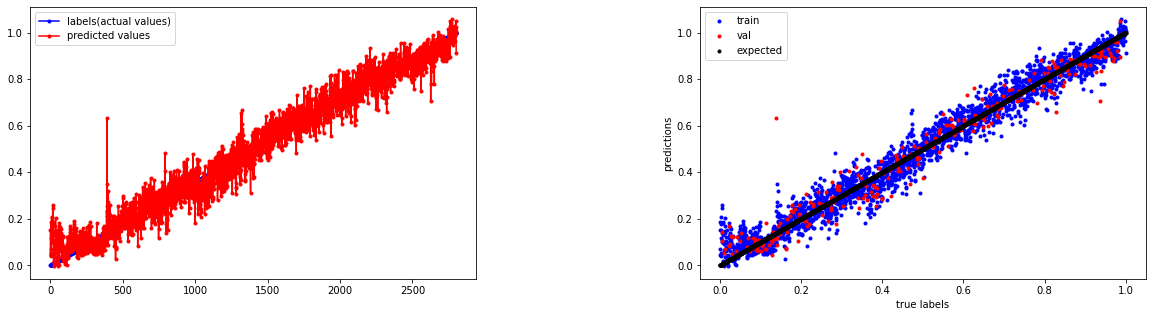

In [20]:
train1_pfiles = [pkzfiles_path+'bearing1_1_train_data.pkz']
val1_pfiles = [pkzfiles_path+'bearing1_1_val_data.pkz']
train1_dataset = PHMDataset(pfiles=train1_pfiles)
val1_dataset = PHMDataset(pfiles=val1_pfiles)

train1_dataloader = DataLoader(train1_dataset, batch_size=64, shuffle=False, num_workers=1)
val1_dataloader = DataLoader(val1_dataset, batch_size=64, shuffle=False, num_workers=1)

train1_results = model_inference_helper(model, train1_dataloader)
val1_results = model_inference_helper(model, val1_dataloader)
results = {'labels': train1_results['labels']+val1_results['labels'], 'predictions': train1_results['predictions']+val1_results['predictions']}
results = sort_results(results)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[20,5])
ax[0].plot(range(len(results['labels'])), results['labels'], 'b.-', label='labels(actual values)')
ax[0].plot(range(len(results['predictions'])), results['predictions'], 'r.-', label='predicted values')
ax[0].legend()
ax[1].scatter(train1_results['labels'], train1_results['predictions'], marker='.', c='b', label='train')
ax[1].scatter(val1_results['labels'], val1_results['predictions'], marker='.', c='r', label='val')
ax[1].scatter(results['labels'], results['labels'], marker='.', c='k', label='expected')
ax[1].set_xlabel('true labels')
ax[1].set_ylabel('predictions')
ax[1].legend()
plt.subplots_adjust(wspace=0.5)
plt.show()

### Bearing1_2

In [ ]:
train1_pfiles = [pkzfiles_path+'bearing1_2_train_data.pkz']
val1_pfiles = [pkzfiles_path+'bearing1_2_val_data.pkz']
train1_dataset = PHMDataset(pfiles=train1_pfiles)
val1_dataset = PHMDataset(pfiles=val1_pfiles)

train1_dataloader = DataLoader(train1_dataset, batch_size=64, shuffle=False, num_workers=1)
val1_dataloader = DataLoader(val1_dataset, batch_size=64, shuffle=False, num_workers=1)

train1_results = model_inference_helper(model, train1_dataloader)
val1_results = model_inference_helper(model, val1_dataloader)
results = {'labels': train1_results['labels']+val1_results['labels'], 'predictions': train1_results['predictions']+val1_results['predictions']}
results = sort_results(results)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[20,5])
ax[0].plot(range(len(results['labels'])), results['labels'], 'b.-', label='labels(actual values)')
ax[0].plot(range(len(results['predictions'])), results['predictions'], 'r.-', label='predicted values')
ax[0].legend()
ax[1].scatter(train1_results['labels'], train1_results['predictions'], marker='.', c='b', label='train')
ax[1].scatter(val1_results['labels'], val1_results['predictions'], marker='.', c='r', label='val')
ax[1].scatter(results['labels'], results['labels'], marker='.', c='k', label='expected')
ax[1].set_xlabel('true labels')
ax[1].set_ylabel('predictions')
ax[1].legend()
plt.subplots_adjust(wspace=0.5)
plt.show()

### Bearing 2_1

In [ ]:
train1_pfiles = [pkzfiles_path+'bearing2_1_train_data.pkz']
val1_pfiles = [pkzfiles_path+'bearing2_1_val_data.pkz']
train1_dataset = PHMDataset(pfiles=train1_pfiles)
val1_dataset = PHMDataset(pfiles=val1_pfiles)

train1_dataloader = DataLoader(train1_dataset, batch_size=64, shuffle=False, num_workers=1)
val1_dataloader = DataLoader(val1_dataset, batch_size=64, shuffle=False, num_workers=1)

train1_results = model_inference_helper(model, train1_dataloader)
val1_results = model_inference_helper(model, val1_dataloader)
results = {'labels': train1_results['labels']+val1_results['labels'], 'predictions': train1_results['predictions']+val1_results['predictions']}
results = sort_results(results)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[20,5])
ax[0].plot(range(len(results['labels'])), results['labels'], 'b.-', label='labels(actual values)')
ax[0].plot(range(len(results['predictions'])), results['predictions'], 'r.-', label='predicted values')
ax[0].legend()
ax[1].scatter(train1_results['labels'], train1_results['predictions'], marker='.', c='b', label='train')
ax[1].scatter(val1_results['labels'], val1_results['predictions'], marker='.', c='r', label='val')
ax[1].scatter(results['labels'], results['labels'], marker='.', c='k', label='expected')
ax[1].set_xlabel('true labels')
ax[1].set_ylabel('predictions')
ax[1].legend()
plt.subplots_adjust(wspace=0.5)
plt.show()

### Bearing 2_2

In [ ]:
train1_pfiles = [pkzfiles_path+'bearing2_2_train_data.pkz']
val1_pfiles = [pkzfiles_path+'bearing2_2_val_data.pkz']
train1_dataset = PHMDataset(pfiles=train1_pfiles)
val1_dataset = PHMDataset(pfiles=val1_pfiles)

train1_dataloader = DataLoader(train1_dataset, batch_size=64, shuffle=False, num_workers=1)
val1_dataloader = DataLoader(val1_dataset, batch_size=64, shuffle=False, num_workers=1)

train1_results = model_inference_helper(model, train1_dataloader)
val1_results = model_inference_helper(model, val1_dataloader)
results = {'labels': train1_results['labels']+val1_results['labels'], 'predictions': train1_results['predictions']+val1_results['predictions']}
results = sort_results(results)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[20,5])
ax[0].plot(range(len(results['labels'])), results['labels'], 'b.-', label='labels(actual values)')
ax[0].plot(range(len(results['predictions'])), results['predictions'], 'r.-', label='predicted values')
ax[0].legend()
ax[1].scatter(train1_results['labels'], train1_results['predictions'], marker='.', c='b', label='train')
ax[1].scatter(val1_results['labels'], val1_results['predictions'], marker='.', c='r', label='val')
ax[1].scatter(results['labels'], results['labels'], marker='.', c='k', label='expected')
ax[1].set_xlabel('true labels')
ax[1].set_ylabel('predictions')
ax[1].legend()
plt.subplots_adjust(wspace=0.5)
plt.show()

### Bearing 3_1

In [ ]:
train1_pfiles = [pkzfiles_path+'bearing3_1_train_data.pkz']
val1_pfiles = [pkzfiles_path+'bearing3_1_val_data.pkz']
train1_dataset = PHMDataset(pfiles=train1_pfiles)
val1_dataset = PHMDataset(pfiles=val1_pfiles)

train1_dataloader = DataLoader(train1_dataset, batch_size=64, shuffle=False, num_workers=1)
val1_dataloader = DataLoader(val1_dataset, batch_size=64, shuffle=False, num_workers=1)

train1_results = model_inference_helper(model, train1_dataloader)
val1_results = model_inference_helper(model, val1_dataloader)
results = {'labels': train1_results['labels']+val1_results['labels'], 'predictions': train1_results['predictions']+val1_results['predictions']}
results = sort_results(results)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[20,5])
ax[0].plot(range(len(results['labels'])), results['labels'], 'b.-', label='labels(actual values)')
ax[0].plot(range(len(results['predictions'])), results['predictions'], 'r.-', label='predicted values')
ax[0].legend()
ax[1].scatter(train1_results['labels'], train1_results['predictions'], marker='.', c='b', label='train')
ax[1].scatter(val1_results['labels'], val1_results['predictions'], marker='.', c='r', label='val')
ax[1].scatter(results['labels'], results['labels'], marker='.', c='k', label='expected')
ax[1].set_xlabel('true labels')
ax[1].set_ylabel('predictions')
ax[1].legend()
plt.subplots_adjust(wspace=0.5)
plt.show()

### Bearing 3_2

In [ ]:
train1_pfiles = [pkzfiles_path+'bearing3_2_train_data.pkz']
val1_pfiles = [pkzfiles_path+'bearing3_2_val_data.pkz']
train1_dataset = PHMDataset(pfiles=train1_pfiles)
val1_dataset = PHMDataset(pfiles=val1_pfiles)

train1_dataloader = DataLoader(train1_dataset, batch_size=64, shuffle=False, num_workers=1)
val1_dataloader = DataLoader(val1_dataset, batch_size=64, shuffle=False, num_workers=1)

train1_results = model_inference_helper(model, train1_dataloader)
val1_results = model_inference_helper(model, val1_dataloader)
results = {'labels': train1_results['labels']+val1_results['labels'], 'predictions': train1_results['predictions']+val1_results['predictions']}
results = sort_results(results)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[20,5])
ax[0].plot(range(len(results['labels'])), results['labels'], 'b.-', label='labels(actual values)')
ax[0].plot(range(len(results['predictions'])), results['predictions'], 'r.-', label='predicted values')
ax[0].legend()
ax[1].scatter(train1_results['labels'], train1_results['predictions'], marker='.', c='b', label='train')
ax[1].scatter(val1_results['labels'], val1_results['predictions'], marker='.', c='r', label='val')
ax[1].scatter(results['labels'], results['labels'], marker='.', c='k', label='expected')
ax[1].set_xlabel('true labels')
ax[1].set_ylabel('predictions')
ax[1].legend()
plt.subplots_adjust(wspace=0.5)
plt.show()